# Bayesian calculation
This notebook was written by Yubo Wang. It contains jupyter notebook code for bayesian calculation in the research of fairness in the XC Running.
## General Question:
As we already using the simulation technique and hypothesis testing to figure out if the historical records had a significant difference compared to the hypothesis distribution. In this part, we are going to calculate which distribution is more likely to generate historical records by using Bayes' theorem.
## Our Approach:
We have two distributions in the calculation, **distribution 1 is the hypothesized distribution in which the win rate is proportional to the school population and the distribution 2 is the distribution generated by the beta model which we simulate top 16 in the state meet for many year**. Our calculation has two parts. In the first part, we will calculate the probability of two distributions when the historical records are given. In the second part, we calculate the probability of generating historical records when each of the distribution is given.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### DataFrames:
#### distribution_df (167$\times$3)
* ID (int): unique school ID number
* pop (int): number of girl students in each school
* freq (int): count of being into first place in the 360,000 simulation based on the beta model

In [2]:
distribution_df = pd.read_csv(r"top1_freq.csv")

## Part 1:
### Introduction:
In this part, we use Bayes' theorem to calculate the probability of having a distribution given a list of schools that are in top 16.
### Concepts:
According to the formula of Bayes' theorem, we have
$$P(A|B)=\frac{P(B|A)\times P(A)}{P(B)}$$
In this part, A is the event that a distribution is generating the result and B is the event that a list of schools being into top 16. Thus, we can modify the formula to:
$$P(\text{having a distribution | a list of schools being into top 16})=\frac{P(\text{probability of having a list of school | a distribution is used})\times P(\text{probability of having a distribution)}}{P(\text{probability of having a list of school})}$$
### Variables:
* temp_school_selected (list of int): a temp variable to store which schools are already been traversed
* temp: a temp variable to store the result of probability of having a list of school given a specific distribution
* pri: $P(\text{probability of having a list of school | a distribution is used})$
* evid: $P(\text{probability of having a list of school})$

In [3]:
def bayesian(select, schools_selected=[], given_distribution=1, hypo1=0.5, hypo2=0.5):
    """
    this function calculate the probability of distribution given schools that are in top 16
    params:
        select: a list of schools that are in top 16
        schools_selected: a list of schools that we finish calculate
        given_distribution: which distribution is calculated (1 or 2)
        hypo1: hypothesized probability of being distribution 1
        hypo2: hypothesized probability of being distribution 2
    return: the probability of given distribution based on the selected schools
    """
    temp_school_selected = schools_selected.copy()
    pri = 1
    for school in select:
        # calculate the probability of each school in the list using the given distribution
        temp = float(a_given_b(school, temp_school_selected, given_distribution))
        pri *= temp
        temp_school_selected.append(school)
    
    temp_school_selected = schools_selected.copy()
    evid = 1
    for school in select:
        # calculate the probability of each school in the list using the other distribution
        temp = float(a_given_b(school, temp_school_selected, 3-given_distribution))
        evid *= temp
        temp_school_selected.append(school)

    evid *= hypo2
    evid += (pri * hypo1)

    return pri * hypo1 / evid

In [4]:
def a_given_b(select, schools_selected=[], distribution=1):
    """
    this function calculate the probability of a single school being into top 16 with the given distribution
    params:
        select: ID of school that are in top 16
        schools_selected: a list of schools that we finish calculate
        distribution: which distribution is calculated (1 or 2)
    return: a school being into top 16 with the given distribution
    """
    if distribution == 1:
        # distribution 1 is the hypothesized distribution which the win rate is proportional to the population
        ret = distribution_df[distribution_df["ID"]==select]["pop"]
        ret /= distribution_df.loc[distribution_df["ID"].isin([i for i in distribution_df["ID"] if i not in schools_selected]), "pop"].sum()
    
    elif distribution == 2:
        # distribution 2 is the based on the beta model
        ret = distribution_df[distribution_df["ID"]==select]["freq"]
        ret /= distribution_df.loc[distribution_df["ID"].isin([i for i in distribution_df["ID"] if i not in schools_selected]), "freq"].sum()

    if ret.empty:
        return 0
    return float(ret)

## Part 1 Graphs:
### Introduction:
In this part, we plot two graphs to visualize the probability of having each distribution in each year and with each average population
* graph 1: The graph shows that the probability of having the distribution in each year, the x-axis is year and y-axis is the probability.
* graph 2: The graph shows that the probability of having the distribution in each average population in each year, the x-axis is average population from each year and y-axis is the probability.
### Variables:
* d1 (list of float): probability of having distribution 1
* d2 (list of float): probability of having distribution 2
* years (list of int): year number
* pop (list of int): average population in each year

school with ID 112 is not in records
school with ID 330 is not in records
school with ID 320 is not in div1, it has pop 332
school with ID 112 is not in records
school with ID 242 is not in div1, it has pop 386
school with ID 242 is not in div1, it has pop 386
school with ID 242 is not in div1, it has pop 386
school with ID 242 is not in div1, it has pop 386
school with ID 242 is not in div1, it has pop 386
school with ID 303 is not in records
school with ID 168 is not in records
school with ID 736 is not in div1, it has pop 409


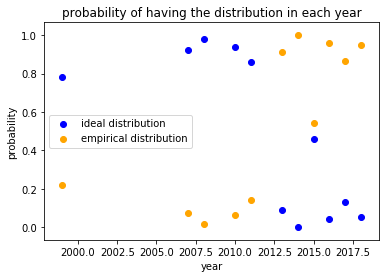

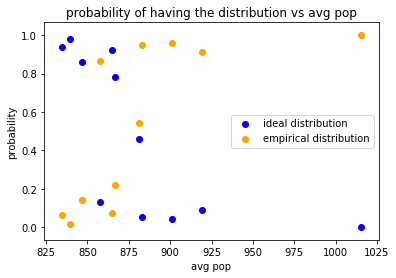

In [5]:
d1 = []
d2 = []
years = []
pop = []

df_all = pd.read_csv(r"div1.csv")
all_div = pd.read_csv(r"allxc.csv")

for year in range(df_all["year"].min(), df_all["year"].max()+1):
    current = df_all[df_all["year"]==year]["school ID"].tolist()[:16]

    c = False
    for i in current:
        # filter our the schools that are not in div1 or not in the historical records
        if i not in distribution_df.values:
            df = all_div[all_div["ID"]==i]
            if not df.empty:
                print("school with ID {} is not in div1, it has pop {}".format(i, int(df["pop"])))
            else:
                print("school with ID {} is not in records".format(i))
            c = True
    if c:
        continue

    years.append(year)
    pop.append(df_all[df_all["year"]==year]["pop"].mean())
    d1.append(bayesian(current, schools_selected=[], given_distribution=1, hypo1=0.5, hypo2=0.5))
    d2.append(bayesian(current, schools_selected=[], given_distribution=2, hypo1=0.5, hypo2=0.5))

plt.scatter(years,d1,c="blue", label="ideal distribution")
plt.scatter(years,d2,c="orange", label="empirical distribution")
plt.legend()
plt.title("probability of having the distribution in each year")
plt.xlabel("year")
plt.ylabel("probability")
plt.savefig('probability of having the distribution in each year', transparent=True)
plt.show()

plt.scatter(pop,d1,c="blue", label="ideal distribution")
plt.scatter(pop,d2,c="orange", label="empirical distribution")
plt.legend()
plt.title("probability of having the distribution vs avg pop")
plt.xlabel("avg pop")
plt.ylabel("probability")
plt.savefig('probability of having the distribution vs avg pop', transparent=True)
plt.show()

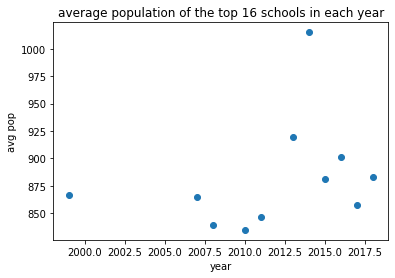

In [6]:
plt.title("average population of the top 16 schools in each year")
plt.scatter(years, pop)
plt.xlabel("year")
plt.ylabel("avg pop")
plt.savefig('average population of the top 16 schools in each year', transparent=True)
plt.show()

## Part 2:
### Introduction:
In this part, we use Bayes' theorem to calculate the probability of having a list of schools that in top 16 given a distribution.
### Concepts:
According to the formula of Bayes' theorem, we have
$$P(A|B)=\frac{P(B|A)\times P(A)}{P(B)}$$
In this part, A is the event that a distribution is generating the result and B is the event that a list of schools being into top 16. Thus, we can modify the formula to:
$$P(\text{a list of schools being into top 16 | having a distribution})=\frac{P(\text{a distribution is used | probability of having a list of school})\times P(\text{probability of having a list of school)}}{P(\text{a distribution is used})}$$
### Variables:
* temp_school_selected (list of int): a temp variable to store which schools are already been traversed
* distribution_given_school (float): $P(\text{a distribution is used | probability of having a list of school})$
* d1: probability of the list of schools being into top 16 is generated by distribution 1
* d2: probability of the list of schools being into top 16 is generated by distribution 2
* p_school: $P(\text{probability of having a list of school})$

In [9]:
def result_given_distribution(select, schools_selected=[], given_distribution=1, hypo1=0.5, hypo2=0.5):
    """
    this function calculate the probability of a list of schools being into top 16 with the given distribution
    params:
        select: a list of schools that are in top 16
        schools_selected: a list of schools that we finish calculate
        given_distribution: which distribution is calculated (1 or 2)
        hypo1: hypothesized probability of being distribution 1
        hypo2: hypothesized probability of being distribution 2
    return: the probability of given distribution based on the selected schools
    """
    distribution_given_school = bayesian(select, schools_selected, given_distribution, hypo1, hypo2)

    temp_school_selected = schools_selected.copy()
    d1 = 1
    for school in select:
        temp = float(a_given_b(school, temp_school_selected, given_distribution))
        d1 *= temp
        temp_school_selected.append(school)
    
    temp_school_selected = schools_selected.copy()
    d2 = 1
    for school in select:
        temp = float(a_given_b(school, temp_school_selected, 3-given_distribution))
        d2 *= temp
        temp_school_selected.append(school)
        
    p_school = d1 * hypo1 + d2 * hypo2

    return distribution_given_school * p_school / hypo1

## Part 2 Graphs:
### Introduction:
In this part, we plot two graphs to visualize the probability of generating the list of schools being into top 16 by each distribution in each year and with each average population
* graph 5: The graph shows that the probability of generating the list of schools being into top 16 by each distribution in each year, the x-axis is year and y-axis is the probability.
* graph 6: The graph shows that the probability of generating the list of schools being into top 16 by each distribution with each average population in each year, the x-axis is average population from each year and y-axis is the probability.
### Variables:
* d1 (list of float): probability of generating the list of schools being into top 16 by distribution 1
* d2 (list of float): probability of generating the list of schools being into top 16 by distribution 2
* years (list of int): year number
* pop (list of int): average population in each year
### DataFrames:
#### Historical records of schools in division 1 (353$\times$6)
df_all
* place (int): place in the running competition at a specific year
* school (str): school name
* score (int): score in the running competition at a specific year
* year (int): time of running competition
* school ID (int): unique school ID number
* pop (int): number of girl students in school
#### information of all schools (502$\times$4)
all_div
* ID (int): unique school ID number
* name (str): school name
* pop (int): number of girl students in school
* div (str): I, II, or III depending on size

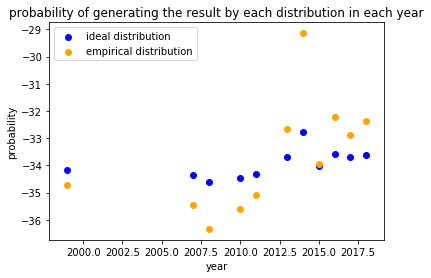

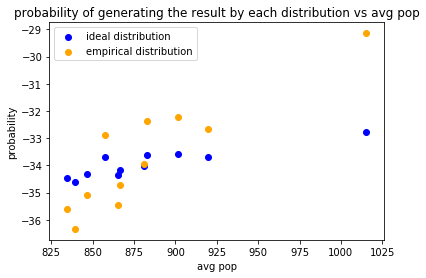

In [10]:
d1 = []
d2 = []
years = []
pop = []

df_all = pd.read_csv(r"div1.csv")
all_div = pd.read_csv(r"allxc.csv")

for year in range(df_all["year"].min(), df_all["year"].max()+1):
    current = df_all[df_all["year"]==year]["school ID"].tolist()[:16]
    
    c = False
    for i in current:
        if i not in distribution_df.values:
            # df = all_div[all_div["ID"]==i]
            # if not df.empty:
            #     print("school with ID {} is not in div1, it has pop {}".format(i, int(df["pop"])))
            # else:
            #     print("school with ID {} is not in records".format(i))
            c=True
    if c:
        continue

    years.append(year)
    pop.append(df_all[df_all["year"]==year]["pop"].mean())
    d1.append(result_given_distribution(current, schools_selected=[], given_distribution=1, hypo1=0.5, hypo2=0.5))
    d2.append(result_given_distribution(current, schools_selected=[], given_distribution=2, hypo1=0.5, hypo2=0.5))

plt.scatter(years,np.log10(d1),c="blue", label="ideal distribution")
plt.scatter(years,np.log10(d2),c="orange", label="empirical distribution")
plt.legend()
plt.title("probability of generating the result by each distribution in each year")
plt.xlabel("year")
plt.ylabel("probability")
plt.savefig('probability of generating the result by each distribution in each year', transparent=True)
plt.show()

plt.scatter(pop,np.log10(d1),c="blue", label="ideal distribution")
plt.scatter(pop,np.log10(d2),c="orange", label="empirical distribution")
plt.legend()
plt.title("probability of generating the result by each distribution vs avg pop")
plt.xlabel("avg pop")
plt.ylabel("probability")
plt.savefig('probability of generating the result by each distribution vs avg pop', transparent=True)
plt.show()